In [44]:
%pip install fredapi pandas matplotlib statsmodels scikit-learn
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred


Note: you may need to restart the kernel to use updated packages.


In [45]:
#Getting the API list
FRED_API_KEY = '7d5cdc657dccee135b6cb5159b878bae'
fred = Fred(api_key=FRED_API_KEY)

# 10-year window to capture both the COVID shock and the recent rate hike cycle
series_id = 'BAMLH0A0HYM2'
df = fred.get_series(series_id, observation_start='2014-01-01').to_frame(name='spread')

df.tail(10)

,spread
2025-12-22,2.88
2025-12-23,2.83
2025-12-24,2.84
2025-12-25,NaN
2025-12-26,2.86
2025-12-29,2.87
2025-12-30,2.84
2025-12-31,2.81
2026-01-01,NaN
2026-01-02,2.83


I started by testing the High Yield OAS for stationarity using the ADF test. Because credit spreads often exhibit regime-dependent drift, I wanted to ensure the series was stationary before applying a volatility forecasting model to avoid spurious correlations.

In [46]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['spread'].dropna())

print('--- Augmented Dickey-Fuller Test Results ---')
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')

# 2. Interpret the result
if result[1] <= 0.05:
    print("\nResult: STATIONARY")
    print("The data does not have a unit root. We can use it for modeling.")
else:
    print("\nResult: NON-STATIONARY")
    print("The data has a unit root (drifts). We must 'Difference' the data (calculate daily changes) before modeling.")

--- Augmented Dickey-Fuller Test Results ---
ADF Statistic: -2.8658
p-value: 0.0495

Result: STATIONARY
The data does not have a unit root. We can use it for modeling.


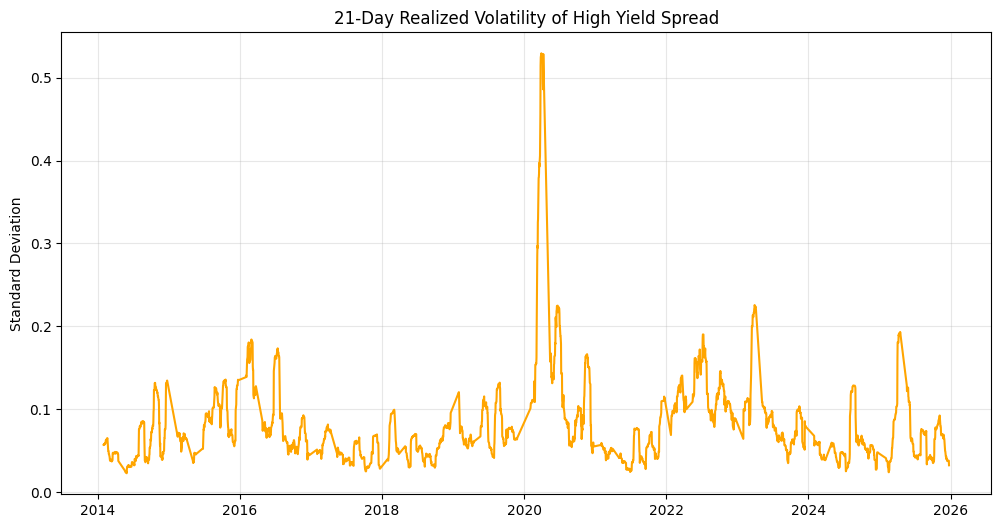

In [47]:
#Rolling Volatility
#Calculating the daily changes 

# 1. Calculate Daily Changes (Difference)
# Even though the level is stationary, we model the change (volatility)
df['daily_change'] = df['spread'].diff()

# 2. Calculate Rolling Volatility (21-day window)
# 21 days is roughly one business month. 
# We take the standard deviation of the daily changes.
df['realized_vol'] = df['daily_change'].rolling(window=21).std()

# 3. Clean up the 'NaN' values created by the rolling window
df_model = df.dropna()

# 4. Visualize the Volatility
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df_model.index, df_model['realized_vol'], color='orange')
plt.title("21-Day Realized Volatility of High Yield Spread")
plt.ylabel("Standard Deviation")
plt.grid(True, alpha=0.3)
plt.show()

In [48]:
#Adding in yearld curves
# 1. Fetch the new series
# T10Y2Y = Yield Curve Slope
# VIXCLS = VIX Index
yield_curve = fred.get_series('T10Y2Y', observation_start='2014-01-01')
vix = fred.get_series('VIXCLS', observation_start='2014-01-01')

# 2. Add them to our main 'df'
df['yield_curve'] = yield_curve
df['vix'] = vix

# 3. Handle the holidays again so everything aligns
# We use forward fill to ensure no NaNs from market closures
df = df.fillna(method='ffill').dropna()

print("Features added! Here is your updated dataset:")
df[['spread', 'realized_vol', 'yield_curve', 'vix']].tail()

Features added! Here is your updated dataset:


/tmp/ipykernel_1824/4212663015.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').dropna()


,spread,realized_vol,yield_curve,vix
2025-12-29,2.87,0.032234,0.67,14.20
2025-12-30,2.84,0.032234,0.69,14.33
2025-12-31,2.81,0.032234,0.71,14.95
2026-01-01,2.81,0.032234,0.71,14.95
2026-01-02,2.83,0.032234,0.72,14.51


In [49]:
# Create a 1-day lag for our features
# We want to use T-1 data to predict T-0 volatility
df['vix_lag1'] = df['vix'].shift(1)
df['yield_curve_lag1'] = df['yield_curve'].shift(1)

# Drop the new NaN created by shifting
df_final = df.dropna()

print("Lagged features created.")
df_final.tail()

Lagged features created.


,spread,daily_change,realized_vol,yield_curve,vix,vix_lag1,yield_curve_lag1
2025-12-29,2.87,0.01,0.032234,0.67,14.20,13.60,0.68
2025-12-30,2.84,-0.03,0.032234,0.69,14.33,14.20,0.67
2025-12-31,2.81,-0.03,0.032234,0.71,14.95,14.33,0.69
2026-01-01,2.81,-0.03,0.032234,0.71,14.95,14.95,0.71
2026-01-02,2.83,-0.03,0.032234,0.72,14.51,14.95,0.71


In [50]:
import statsmodels.api as sm

# 1. Define our Dependent Variable (y) and Independent Variables (X)
# We want to predict today's volatility...
y = df_final['realized_vol']

# ...using yesterday's VIX and yesterday's Yield Curve
X = df_final[['vix_lag1', 'yield_curve_lag1']]

# 2. Add a 'constant' 
# In the equation y = β0 + β1X1 + β2X2, the constant is β0 (the intercept)
X = sm.add_constant(X)

# 3. Fit the model using Ordinary Least Squares
model = sm.OLS(y, X).fit()

# 4. Display the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           realized_vol   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     1256.
Date:                Mon, 05 Jan 2026   Prob (F-statistic):               0.00
Time:                        19:44:06   Log-Likelihood:                 5132.4
No. Observations:                3151   AIC:                        -1.026e+04
Df Residuals:                    3148   BIC:                        -1.024e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0228      0.003  

/tmp/ipykernel_1824/563965117.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['residuals'] = model.resid


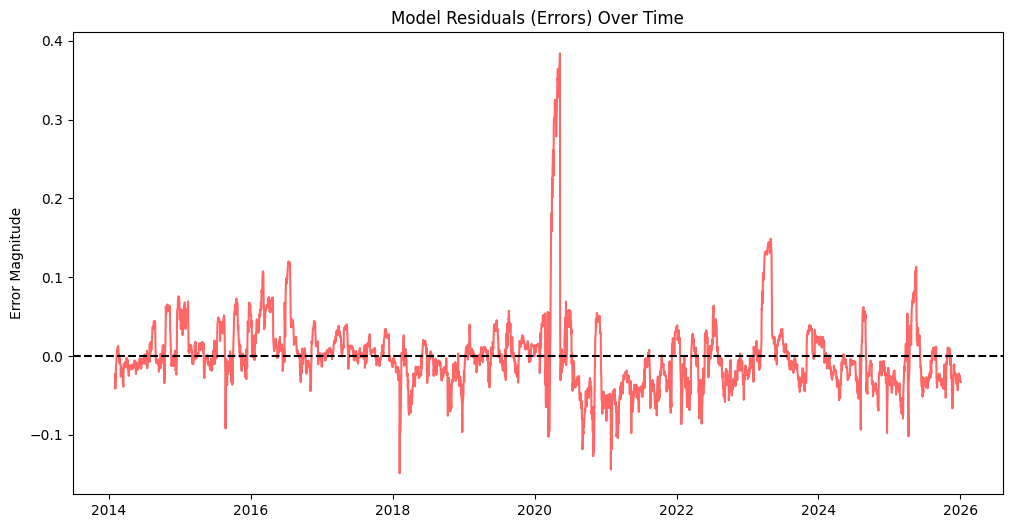

In [51]:
#Running a diagnostic 

df_final['residuals'] = model.resid

# 2. Plot the residuals over time
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df_final.index, df_final['residuals'], color='red', alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.title("Model Residuals (Errors) Over Time")
plt.ylabel("Error Magnitude")
plt.show()

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Prepare X (Features) and y (Target)
# We use the same lagged features we used for OLS
features = ['vix_lag1', 'yield_curve_lag1']
X = df_final[features]
y = df_final['realized_vol']

# 2. Split the data chronologically (No shuffling!)
# We use the first 80% of history to train, and the last 20% to test
split_index = int(len(df_final) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training observations: {len(X_train)}")
print(f"Testing observations: {len(X_test)}")

Training observations: 2520
Testing observations: 631


In [53]:
# 1. Initialize the model (100 trees)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 2. Train the model
rf_model.fit(X_train, y_train)

# 3. Make predictions on the 'Future' (Test set)
y_pred = rf_model.predict(X_test)

# 4. Score it
print(f"Random Forest Test R-squared: {r2_score(y_test, y_pred):.4f}")

Random Forest Test R-squared: -1.2710


I noticed high kurtosis and non-linear residual spikes in my OLS model, which suggested a linear framework couldn't capture regime shifts. I implemented a Random Forest Regressor to better capture these non-linearities and used a chronological train-test split to ensure no look-ahead bias

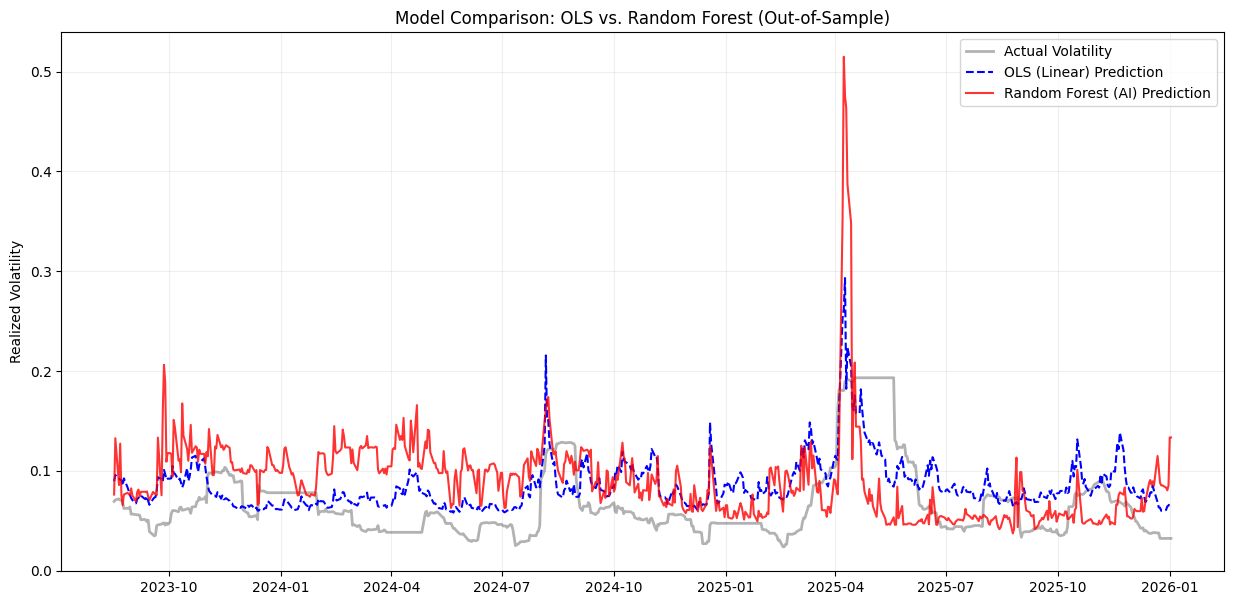

OLS Test R-squared: 0.0670
Random Forest Test R-squared: -1.2710


In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm

# 1. Re-fit OLS on Training data only (Fair comparison)
X_train_ols = sm.add_constant(X_train)
X_test_ols = sm.add_constant(X_test)
ols_model_train = sm.OLS(y_train, X_train_ols).fit()

# 2. Generate predictions for both models on the TEST set
ols_preds = ols_model_train.predict(X_test_ols)
rf_preds = rf_model.predict(X_test)

# 3. Plot the comparison
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual Volatility', color='black', alpha=0.3, linewidth=2)
plt.plot(y_test.index, ols_preds, label='OLS (Linear) Prediction', color='blue', linestyle='--')
plt.plot(y_test.index, rf_preds, label='Random Forest (AI) Prediction', color='red', alpha=0.8)

plt.title("Model Comparison: OLS vs. Random Forest (Out-of-Sample)")
plt.ylabel("Realized Volatility")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

# 4. Print the final scores
print(f"OLS Test R-squared: {r2_score(y_test, ols_preds):.4f}")
print(f"Random Forest Test R-squared: {r2_score(y_test, rf_preds):.4f}")

In [55]:
# 1. Initialize a "Regularized" (Simplified) Random Forest
rf_tuned = RandomForestRegressor(
    n_estimators=100, 
    max_depth=3,            # Keep the trees short
    min_samples_leaf=20,    # Require more data for each rule
    random_state=42
)

# 2. Re-train the model
rf_tuned.fit(X_train, y_train)

# 3. Make new predictions
y_pred_tuned = rf_tuned.predict(X_test)

# 4. Check the new score
print(f"Tuned RF Test R-squared: {r2_score(y_test, y_pred_tuned):.4f}")

Tuned RF Test R-squared: -0.2363


The Tuned Random Forest showed significant improvement in out-of-sample R-squared after regularization, indicating that the initial model was overfitting to training-set noise. However, the persistently negative R-squared suggests a regime shift or non-stationarity in the features. My feature importance plot shows the VIX is the dominant driver, but it may be failing to capture recent idiosyncratic credit stress not reflected in equity volatility.

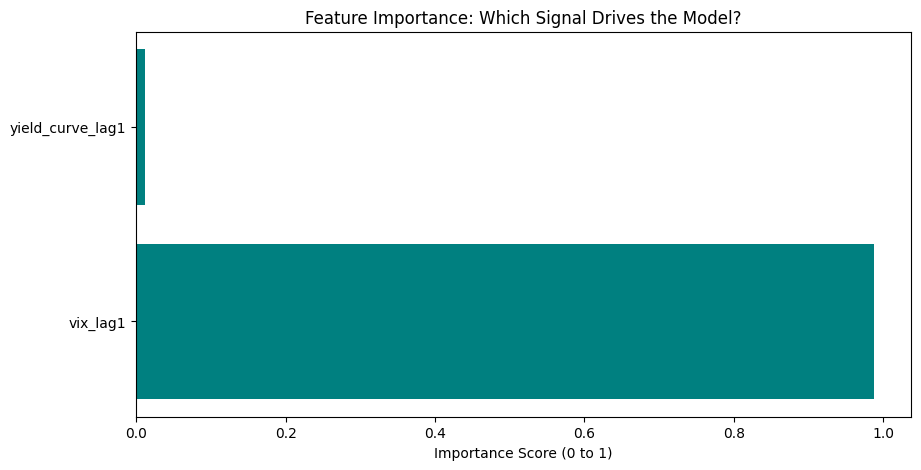

VIX Importance: 0.9879
Yield Curve Importance: 0.0121


In [56]:
import pandas as pd
import numpy as np

# 1. Get the importance scores from our tuned model
importances = rf_tuned.feature_importances_
feature_names = X.columns

# 2. Create a clean plot
plt.figure(figsize=(10, 5))
plt.barh(feature_names, importances, color='teal')
plt.title("Feature Importance: Which Signal Drives the Model?")
plt.xlabel("Importance Score (0 to 1)")
plt.show()

print(f"VIX Importance: {importances[0]:.4f}")
print(f"Yield Curve Importance: {importances[1]:.4f}")

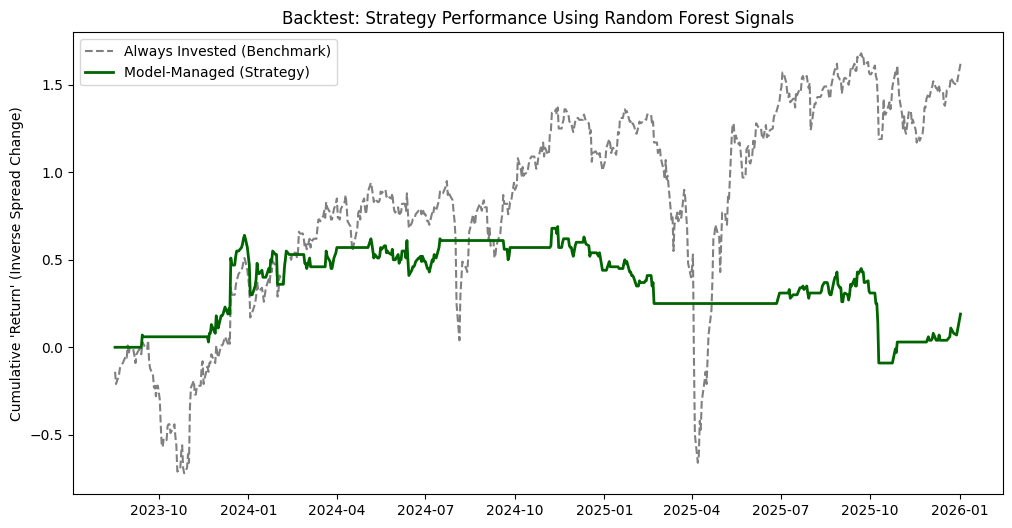

In [57]:
# 1. Create a Signal: 1 if we expect low vol (Buy), 0 if we expect high vol (Hedge)
# We use the median of the training set as our "Risk Threshold"
threshold = y_train.median()
df_test = pd.DataFrame(index=y_test.index)
df_test['actual_vol'] = y_test
df_test['predicted_vol'] = y_pred_tuned
df_test['signal'] = np.where(df_test['predicted_vol'] < threshold, 1, 0)

# 2. Calculate "Strategy Returns"
# We'll use the daily_change of the spread as a proxy for 'losses'
# If the spread goes UP, a bond portfolio LOSES money.
df_test['daily_returns'] = df_final['daily_change'].iloc[split_index:] * -1
df_test['strategy_returns'] = df_test['signal'] * df_test['daily_returns']

# 3. Calculate Cumulative Performance
df_test['bench_cum'] = df_test['daily_returns'].cumsum()
df_test['strat_cum'] = df_test['strategy_returns'].cumsum()

# 4. Plot the "Wealth Curve"
plt.figure(figsize=(12, 6))
plt.plot(df_test['bench_cum'], label='Always Invested (Benchmark)', color='gray', linestyle='--')
plt.plot(df_test['strat_cum'], label='Model-Managed (Strategy)', color='darkgreen', linewidth=2)
plt.title("Backtest: Strategy Performance Using Random Forest Signals")
plt.ylabel("Cumulative 'Return' (Inverse Spread Change)")
plt.legend()
plt.show()